<h1 align="center" style="background-color:black;color:white;border-radius: 8px; padding:15px">English to Yoruba Translation: A beginner's approach to Seq2Seq Modeling</h1>

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">1. Download and import required libraries</h3>

In [50]:
# Installation required due to
# Deprecation of TorchText - check https://github.com/pytorch/text/issues/2250
# Restart Kernel after installation
# !pip install torch==2.2.0 torchtext==0.17.0 >> null

In [58]:
import os
import random 
import gc
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict

import torch
from torch.utils.data import random_split, DataLoader
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Just some lil configurations

sns.set_style('darkgrid')

random_seed=42
torch.manual_seed(random_seed);

import warnings
warnings.filterwarnings('ignore')

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">2. Load Dataset</h3>

In [4]:
raw_df = pd.read_csv('english-yoruba-dataset/train.csv')

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">3. Data Exploration</h3>

In [5]:
# View first five rows
raw_df.head()

,ID,Yoruba,English
0,ID_AAJEQLCz,A ṣètò Ìgbìmọ̀ Tó Ń Ṣètò Ìrànwọ́ Nígbà Àjálù l...,A Disaster Relief Committee was formed to orga...
1,ID_AASNedba,"Ìrọ̀lẹ́ May 22, 2018 ni wọ́n fàṣẹ ọba mú Arákù...",Brother Solovyev was arrested on the evening o...
2,ID_AAeQrhMq,Iléeṣẹ́ Creative Commons náà,Creative Commons the Organization
3,ID_AAxlMgPP,"Pè̩lú Egypt, Morocco àti Tunisia tí wó̩n ti lo...","With Egypt, Morocco and Tunisia out of the Wor..."
4,ID_ABKuMKSx,Adájọ́ àgbà lórílẹ̀ èdè Náíjíríà (Attorney Gen...,"The Attorney General of the Federation, Justic..."


In [6]:
# Show the size/shape of data
raw_df.shape

(10054, 3)

In [7]:
# Print 3 random English sentence and Yoruba Translation

sample_df = raw_df.sample(3)

for eng, yor in zip(sample_df['English'].values, sample_df['Yoruba'].values):
    
    print(f'{eng}\n{yor}', end='\n\n')

Brother Klimov was arrested on June 3, 2018, after law enforcement, including special forces, invaded two homes of Jehovah’s Witnesses.
Wọ́n mú arákùnrin Klimov ní June 3, 2018, nígbà táwọn agbófinró àtàwọn ẹ̀ṣọ́ aláàbò ya wọ ilé àwọn Elẹ́rìí Jèhófà méjì.

When the project is complete, the final design will be in the style of apartments commonly available in the area with a separate office building, as shown in the rendering above.
Tá a bá ti kọ́ ilé náà tán, àwọn ilé gbígbé tó wà níbẹ̀ máa rí bíi tàwọn ilé tó wọ́pọ̀ ládùúgbò náà, àwọn ọ́fíìsì sì máa wà lọ́tọ̀ bó ṣe wà nínú fọ́tò tó wà lókè yìí.

No one ever sees the leavings of the god Orò.
A kì í rí àjẹkù orò.



In [8]:
# Drop ID column
raw_df = raw_df.drop(columns='ID')

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">4. Data Visualization</h3>

In [9]:
# Create wordcloud function
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=14)
    ax.axis('off')

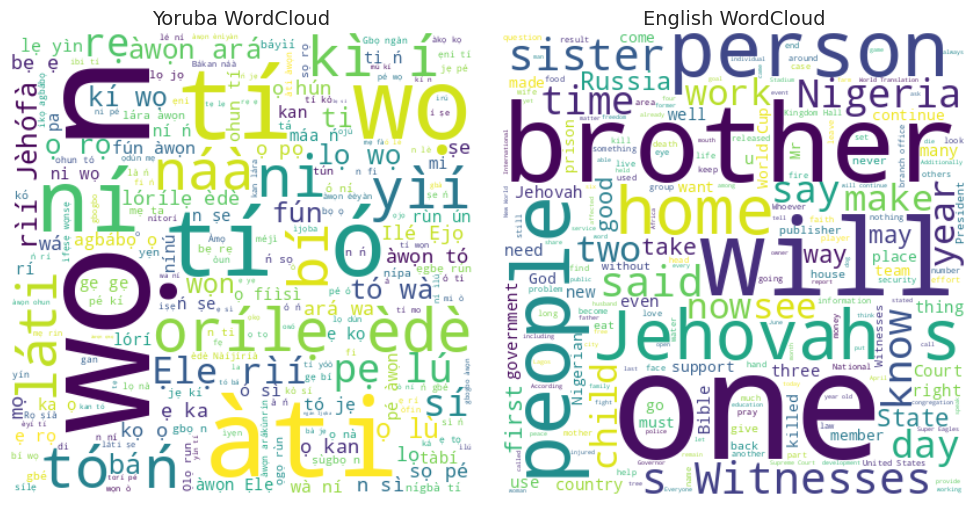

In [10]:
# Combine Yoruba and English texts
yoruba_text = ' '.join(raw_df['Yoruba'].tolist())
english_text = ' '.join(raw_df['English'].tolist())

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Generate wordclouds for Yoruba and English
generate_wordcloud(yoruba_text, 'Yoruba WordCloud', axes[0])
generate_wordcloud(english_text, 'English WordCloud', axes[1])

plt.tight_layout()
plt.show()

Russia keh 👀 Abeg ooo

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">5. Split Dataset into Training, Validation and Test Set</h3>

"It is important to note that a vocabulary should only be built from the training set and never the validation or test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores." - <a href="https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb">bentrevett</a>

In [11]:
# First, split into train and test (90% train, 10% test)
train_df, test_df = train_test_split(raw_df, test_size=0.1, random_state=42)

# Then split train into train and validation (90% train, 10% validation of the remaining 90%)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Train set: (8143, 2)
Validation set: (905, 2)
Test set: (1006, 2)


<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">6. Convert pandas dataframes to Hugging Face datasets</h3>

The datasets library from Hugging Face have a lot of utility functions I don't need to write myself 

In [12]:
train_data = Dataset.from_pandas(train_df, preserve_index=False)
val_data = Dataset.from_pandas(val_df, preserve_index=False)
test_data = Dataset.from_pandas(test_df, preserve_index=False)

# Create a DatasetDict
dataset_dict = DatasetDict({
    'train': train_data,
    'validation': val_data,
    'test': test_data
})

In [13]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['Yoruba', 'English'],
        num_rows: 8143
    })
    validation: Dataset({
        features: ['Yoruba', 'English'],
        num_rows: 905
    })
    test: Dataset({
        features: ['Yoruba', 'English'],
        num_rows: 1006
    })
})

In [14]:
train_data[0]

{'Yoruba': 'A kì í wà nínú ìṣẹ́ ká perin tọrẹ.',
 'English': 'One does not wallow in poverty and yet kill an elephant for public distribution.'}

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">7. Tokenization</h3>

This notebook uses a very naive word level tokenizer. Also, I am not trying to get overly complicated with tokenization techniques such as BPE. The objective is to get familiar with the typical Seq2Seq modeling workflow.

In [15]:
# Tokenizer
tokenizer = get_tokenizer('basic_english') # Apologies but I'm going to be using this for both languages 

In [16]:
# Show example tokenization
print(tokenizer('The  jerseys  feature the home kits that pay tribute to  the 1994 squad')) # Not a complete sentence
print(tokenizer('Ẹ̀wẹ̀, aṣọ̀ tuntun ọ̀hún ló ṣàfihàn ẹ̀wù tí ikọ̀ Super-Eagles wọ̀ nínú')) # Not a complete sentence

['the', 'jerseys', 'feature', 'the', 'home', 'kits', 'that', 'pay', 'tribute', 'to', 'the', '1994', 'squad']
['ẹ̀wẹ̀', ',', 'aṣọ̀', 'tuntun', 'ọ̀hún', 'ló', 'ṣàfihàn', 'ẹ̀wù', 'tí', 'ikọ̀', 'super-eagles', 'wọ̀', 'nínú']


In [17]:
def tokenize_example(example, tokenizer, max_length, sos_token, eos_token):
    en_tokens = tokenizer(example['English'])[:max_length]
    yo_tokens = tokenizer(example['Yoruba'])[:max_length]
    
    en_tokens = [sos_token] + en_tokens + [eos_token]
    yo_tokens = [sos_token] + yo_tokens + [eos_token]
    
    return {'en_tokens': en_tokens, 'yo_tokens': yo_tokens}

<Axes: ylabel='Frequency'>

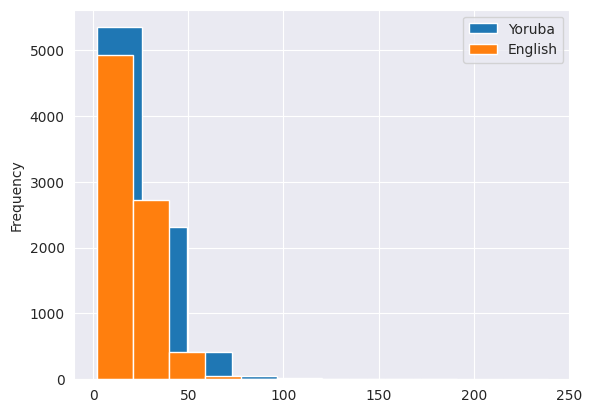

In [18]:
train_df.Yoruba.map(tokenizer).map(len).plot(kind='hist', legend=True)
train_df.English.map(tokenizer).map(len).plot(kind='hist', legend=True)

I'll just go with 55 as my maximum length

In [19]:
max_length = 55
sos_token = '<sos>'
eos_token = '<eos>'

fn_kwargs = {
    'tokenizer': tokenizer,
    'max_length': max_length,
    'sos_token': sos_token,
    'eos_token': eos_token
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
val_data = val_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/8143 [00:00<?, ? examples/s]

Map:   0%|          | 0/905 [00:00<?, ? examples/s]

Map:   0%|          | 0/1006 [00:00<?, ? examples/s]

In [20]:
train_data[0]

{'Yoruba': 'A kì í wà nínú ìṣẹ́ ká perin tọrẹ.',
 'English': 'One does not wallow in poverty and yet kill an elephant for public distribution.',
 'en_tokens': ['<sos>',
  'one',
  'does',
  'not',
  'wallow',
  'in',
  'poverty',
  'and',
  'yet',
  'kill',
  'an',
  'elephant',
  'for',
  'public',
  'distribution',
  '.',
  '<eos>'],
 'yo_tokens': ['<sos>',
  'a',
  'kì',
  'í',
  'wà',
  'nínú',
  'ìṣẹ́',
  'ká',
  'perin',
  'tọrẹ',
  '.',
  '<eos>']}

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">8. Build Vocabularies</h3>

In [21]:
min_freq = 2
unk_token = '<unk>'
pad_token = '<pad>'

special_tokens = [unk_token, pad_token, sos_token, eos_token]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data['en_tokens'],
    min_freq=min_freq,
    specials=special_tokens
)

yo_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data['yo_tokens'],
    min_freq=min_freq,
    specials=special_tokens
)

In [22]:
# Print first ten tokens from both vocabs
print(en_vocab.get_itos()[:10])
print(yo_vocab.get_itos()[:10])

['<unk>', '<pad>', '<sos>', '<eos>', 'the', ',', '.', 'to', 'of', 'and']
['<unk>', '<pad>', '<sos>', '<eos>', ',', '.', 'tí', 'àwọn', 'ní', 'tó']


In [23]:
# Show vocab size
len(en_vocab), len(yo_vocab)

(7622, 6080)

In [24]:
unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

# Set default index for out-of-vocab tokens
en_vocab.set_default_index(unk_index)
yo_vocab.set_default_index(unk_index)

en_vocab['The'] # Access token not present in vocab

0

In [25]:
tokens = ["sinners", "in", "the", "hand", "of", "an", "angry", "god"]

print(en_vocab.lookup_indices(tokens)) # convert a list of tokens to ids

print(en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))) # convert a list of ids to tokens

[0, 10, 4, 343, 8, 43, 2530, 178]
['<unk>', 'in', 'the', 'hand', 'of', 'an', 'angry', 'god']


In [26]:
def numericalize_example(example, en_vocab, yo_vocab):
    """Convert tokens to indices"""
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    yo_ids = yo_vocab.lookup_indices(example["yo_tokens"])
    return {"en_ids": en_ids, "yo_ids": yo_ids}

In [27]:
fn_kwargs = {"en_vocab": en_vocab, "yo_vocab": yo_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
val_data = val_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/8143 [00:00<?, ? examples/s]

Map:   0%|          | 0/905 [00:00<?, ? examples/s]

Map:   0%|          | 0/1006 [00:00<?, ? examples/s]

In [28]:
# Convert IDs to torch tensor

data_type = "torch"
format_columns = ["en_ids", "yo_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

val_data = val_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)

In [29]:
train_data[0]

{'en_ids': tensor([   2,   15,   45,   18,    0,   10, 1009,    9,  269,  315,   43,  756,
           14,  189, 1890,    6,    3]),
 'yo_ids': tensor([   2,   17,   56,   49,   33,   38, 1013,  111,    0, 3782,    5,    3]),
 'Yoruba': 'A kì í wà nínú ìṣẹ́ ká perin tọrẹ.',
 'English': 'One does not wallow in poverty and yet kill an elephant for public distribution.',
 'en_tokens': ['<sos>',
  'one',
  'does',
  'not',
  'wallow',
  'in',
  'poverty',
  'and',
  'yet',
  'kill',
  'an',
  'elephant',
  'for',
  'public',
  'distribution',
  '.',
  '<eos>'],
 'yo_tokens': ['<sos>',
  'a',
  'kì',
  'í',
  'wà',
  'nínú',
  'ìṣẹ́',
  'ká',
  'perin',
  'tọrẹ',
  '.',
  '<eos>']}

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">9. Data Loaders</h3>

"When using nn.utils.rnn.pad_sequence, you need to specify batch_first=True if you expect the output to be in the shape [batch_size, sequence_length]. Otherwise, the output will be [sequence_length, batch_size], which might cause issues downstream, depending on how your model is expecting the input."

In [30]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_yo_ids = [example["yo_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_yo_ids = nn.utils.rnn.pad_sequence(batch_yo_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "yo_ids": batch_yo_ids,
        }
        
        return batch

    return collate_fn

In [31]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [32]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
val_data_loader = get_data_loader(val_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [33]:
for i, batch in enumerate(train_data_loader):
    print(batch["yo_ids"].shape) # output is [sequence_length, batch_size] due to batch_size=False
    print(batch["en_ids"].shape)
    
    print(batch["en_ids"])
    
    break

torch.Size([57, 128])
torch.Size([57, 128])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 202,  116,    4,  ...,    4,  912,    4],
        [ 105,   66,  215,  ..., 1084,   30, 1304],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">10. Encoder</h3>

In [34]:
class Encoder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">11. Decoder</h3>

In [35]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">12. Seq2Seq</h3>

In [36]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">13. Model Initialization</h3>

In [37]:
input_dim = len(en_vocab)
output_dim = len(yo_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

In [38]:
model = Seq2Seq(encoder, decoder, device).to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7622, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6080, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=6080, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [39]:
# weights initialization
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7622, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6080, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=6080, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [40]:
# Count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 13,983,168 trainable parameters


<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">14. Optimizer and Loss Function</h3>

In [41]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">15. Define Training and Evaluation Loop</h3>

In [42]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["en_ids"].to(device)
        trg = batch["yo_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [43]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["en_ids"].to(device)
            trg = batch["yo_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">16. Model Training</h3>

In [60]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        val_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")


 10%|█         | 1/10 [00:25<03:52, 25.79s/it]

	Train Loss:   4.757 | Train PPL: 116.438
	Valid Loss:   5.698 | Valid PPL: 298.125



 20%|██        | 2/10 [00:51<03:23, 25.49s/it]

	Train Loss:   4.695 | Train PPL: 109.432
	Valid Loss:   5.770 | Valid PPL: 320.615



 30%|███       | 3/10 [01:16<02:58, 25.43s/it]

	Train Loss:   4.695 | Train PPL: 109.358
	Valid Loss:   5.633 | Valid PPL: 279.463



 40%|████      | 4/10 [01:41<02:32, 25.43s/it]

	Train Loss:   4.658 | Train PPL: 105.467
	Valid Loss:   5.732 | Valid PPL: 308.504



 50%|█████     | 5/10 [02:07<02:07, 25.40s/it]

	Train Loss:   4.608 | Train PPL: 100.284
	Valid Loss:   5.689 | Valid PPL: 295.702



 60%|██████    | 6/10 [02:32<01:41, 25.38s/it]

	Train Loss:   4.621 | Train PPL: 101.584
	Valid Loss:   5.696 | Valid PPL: 297.535



 70%|███████   | 7/10 [02:57<01:16, 25.36s/it]

	Train Loss:   4.531 | Train PPL:  92.811
	Valid Loss:   5.740 | Valid PPL: 311.006



 80%|████████  | 8/10 [03:23<00:50, 25.37s/it]

	Train Loss:   4.520 | Train PPL:  91.825
	Valid Loss:   5.694 | Valid PPL: 296.997



 90%|█████████ | 9/10 [03:48<00:25, 25.34s/it]

	Train Loss:   4.482 | Train PPL:  88.433
	Valid Loss:   5.681 | Valid PPL: 293.192



100%|██████████| 10/10 [04:13<00:00, 25.39s/it]

	Train Loss:   4.482 | Train PPL:  88.398
	Valid Loss:   5.710 | Valid PPL: 301.939


<h3 style="background-color:black;color:white;border-radius: 8px; padding:15px">17. Model Evaluation</h3>

In [45]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 5.730 | Test PPL: 307.943 |


In [61]:
def translate_sentence(
    sentence,
    model,
    yo_vocab,
    en_vocab,
    sos_token,
    eos_token,
    device,
    max_output_length=25
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token for token in tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        tokens = [sos_token] + tokens + [eos_token]
        ids = en_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        hidden, cell = model.encoder(tensor)
        inputs = yo_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == yo_vocab[eos_token]:
                break
        tokens = yo_vocab.lookup_tokens(inputs)
    return tokens

In [62]:
sentence = train_data[0]["English"]
expected_translation = train_data[0]["Yoruba"]

sentence, expected_translation

('One does not wallow in poverty and yet kill an elephant for public distribution.',
 'A kì í wà nínú ìṣẹ́ ká perin tọrẹ.')

In [63]:
translation = translate_sentence(
    sentence,
    model,
    yo_vocab,
    en_vocab,
    sos_token,
    eos_token,
    device
)

translation

['<sos>', 'a', 'kì', 'í', 'fi', '<unk>', '<unk>', '<unk>', '.', '<eos>']

I just looked at the result and sighed. There is still a long way to go...

See you in the next one 😞

#### References
- https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb